#Neural Encoding

##Written by Gergana Slaveykova s1070004
##Radboud University- B3 Thesis project

#Imports

In [ ]:
#Mount Google Drive to acess data and storing purposes
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Installs
!pip install nibabel
!pip install nilearn
!pip install git+https://github.com/nipy/nipy.git

#Imports
import nibabel as nib
import numpy as np
from nipy.modalities.fmri.experimental_paradigm import load_paradigm_from_csv_file
from nipy.modalities.fmri.design_matrix import make_dmtx
from nipy.labs.viz import plot_map, cm
import matplotlib.pyplot as plt
import pickle
from __future__ import annotations
import os
from types import ModuleType
from typing import Tuple, Union
from nilearn import masking, plotting
from PIL import Image
from scipy.stats import t, zscore
from sklearn.linear_model import RidgeCV
import h5py
import PIL.Image
from scipy import sparse, stats
from scipy.stats import t, zscore
from sklearn.kernel_ridge import KernelRidge
from numpy.linalg import svd
import time
from scipy import signal



#Extracted features loading

In [ ]:
# Define the number of layers
num_layers = 5

#Set the feature paths
train_file_paths = [f'/content/drive/My Drive/newDataExperimentationGOD/objects_features_vgg_tr_{i}.npy' for i in range(0, num_layers + 1)]
test_file_paths = [f'/content/drive/My Drive/newDataExperimentationGOD/objects_features_vgg_te_{i}.npy' for i in range(0, num_layers + 1)]

#feature array initialization
train_features = []
test_features = []

# Load and process train features
for i in range(num_layers):
    print(np.load(train_file_paths[i]).shape)
    train_features.append(np.load(train_file_paths[i]).reshape(1200 if i < 5 else 1200, -1).squeeze())
    print(f"Layer {i + 1} - Train features: {train_features[i].shape}")

# Print separator
print(20 * "=")

# Load and process test features
for i in range(num_layers):
    print(np.load(test_file_paths[i]).shape)
    print(np.load(test_file_paths[i]).reshape(50 if i < 5 else 50, -1).shape)
    print(np.load(test_file_paths[i]).reshape(50 if i < 5 else 50, -1).squeeze().shape)
    test_features.append(np.load(test_file_paths[i]).reshape(50 if i < 5 else 50, -1).squeeze())
    print(f"Layer {i + 1} - Test features: {test_features[i].shape}")

#Linear model

In [ ]:
#Arhitecture of Kernel CV Rigde regression
class KernelRidgeCV:
    def __init__(self, kernel, target, n_lambdas):
        self.kernel = kernel  # Precomputed kernel matrix
        self.target = target  # Target values for the regression
        self.n_lambdas = n_lambdas  # Number of lambda (regularization) values to consider
        self._lambdas = None  # Placeholder for lambda values
        self._df = None  # Placeholder for degrees of freedom

    @property
    def lambdas(self):
        if self._lambdas is not None:
            return self._lambdas

        # Singular Value Decomposition of the kernel matrix
        s = svd(self.kernel)[1]
        s = s[s > 0]

        self._lambdas = np.full((self.n_lambdas), np.nan)
        length = s.shape[0]
        self._df = np.linspace(length, 1, self.n_lambdas)
        mean = np.mean(1/s)

        # Function to find the difference between desired and actual degrees of freedom
        f = lambda df, lamb: df - np.sum(s / (s + lamb))
        f_prime = lambda lamb: np.sum(s / (s + lamb)**2)

        # get all the lambdas
        for i in range(1, self.n_lambdas):
            if i == 1:
                self._lambdas[i] = 0
            else:
                self._lambdas[i] = self._lambdas[i-1]
            self._lambdas[i] = max(self._lambdas[i], (length / self._df[i] - 1) / mean)
            temp = f(self._df[i], self._lambdas[i])
            # Use Newton-Raphson method to refine lambda values
            while abs(temp) > 1e-10:
                self._lambdas[i] = max(0, self._lambdas[i] - temp / f_prime(self._lambdas[i]))
                temp = f(self._df[i], self._lambdas[i])
        return self._lambdas[1:]


    #train loop
    def train(self, X):
        best_model, best_error = None, np.inf

        # Cross-validation over all lambda values
        for lambda_, df_ in zip(self.lambdas, self._df):
            # Initialize Kernel Ridge Regression model with the current lambda
            kernel_ridge = KernelRidge(alpha=lambda_)
            kernel_ridge.fit(X, self.target)
            y = kernel_ridge.predict(X)

            # Compute the error, avoiding division by zero
            print((1 - df_ / self.kernel.shape[0]))
            if  (1 - df_ / self.kernel.shape[0]) != 0:
              error = np.sum(((self.target - y) / (1 - df_ / self.kernel.shape[0])) ** 2)
            else:
            # Set the error to negative infinity to penalize this case
              error = np.
            #this version was having division by 0 which was giving a warning for our case
            #error = np.sum(((self.target - y) / (1 - df_ / self.kernel.shape[0])) ** 2)
            print(f"curr error: {error}")
            if error < best_error:
                best_error = error
                best_model = kernel_ridge
        print("Best error:", best_error, "Alpha: ", best_model.alpha)
        return best_model

In [ ]:
def get_correlations_KERNEL(features_train_layer,features_test_layer,x_tr,x_te):
      """
    Computes the Pearson correlation coefficients between predicted and actual test target values using
    Kernel Ridge Regression with cross-validated lambda (regularization) values.

    Parameters:
    - features_train_layer (np.array): Training set feature representations. These are the features extracted from a particular layer of a model.
    - features_test_layer (np.array): Test set feature representations. These are the features extracted from a particular layer of a model.
    - x_tr (np.array): Target values corresponding to the training set.
    - x_te (np.array): Target values corresponding to the test set.

    Returns:
    - correlation_coefficients (list): List of Pearson correlation coefficients between predicted and actual test target values.
    - x_hat (np.array): Predicted target values for the test set.
    """
    n_te = np.array(x_te).shape[0]# nr examples, test set
    n_tr = np.array(x_tr).shape[0] # nr examples. training set


    # number of lambda values to test w/ grid search
    n = 10
    print(f"Shaape of features test {np.array(features_test_layer).shape}")
    print(f"Shaape of features test {np.array(features_train_layer).shape}")
    # Reshape feature matrices
    f_te = features_test_layer.reshape(n_te, -1)
    f_tr = features_train_layer.reshape(n_tr, -1)

    # k-Ridge @ multiplication brain2gan methods neuroencoding
    # Compute the kernel matrix
    kernel = f_tr @ f_tr.T
    kernel = kernel.astype(float)
    # Initialize Kernel Ridge Regression with cross-validation
    ridge_cv = KernelRidgeCV(kernel, x_tr, n)
    model = ridge_cv.train(f_tr)
    # Predict target values for the test set
    x_hat = model.predict(f_te)
    print("Alpha:", model.alpha)
    y_test = x_te
    # Calculate the Pearson correlation coefficient for the entire response vectors

    correlation_coefficients =pearson_correlation_coefficient(x_hat,y_test,0)
    print(len(correlation_coefficients[0]))
    return correlation_coefficients,x_hat

In [ ]:
def count_occurrences(array,layers_to_study):
  """
    Counts the occurrences of each number in the array within the specified range of layers to study.

    Parameters:
    - array (list or ndarray): The input array containing layer indices.
    - layers_to_study (list): The list of layers to study (1-based indices).

    Returns:
    - counts (list): A list of counts corresponding to the layers to study.
  """
  counts = [0] * len(layers_to_study)  # Initialize counts for numbers 1 to 7
  for num in array:
      if num==0:
        continue
      if 1 <= num <= 8:
          counts[num - 1] += 1  # Increment count for the number
  return counts


def plot_correlations_bar_plot(correlations_list, layers_to_study):
   """
    Identifies significant voxels and determines the most significant layer for each voxel based on correlation coefficients.

    Parameters:
    - correlations_list (list): A list of tuples containing correlation coefficients and p-values for each layer.
    - layers_to_study (list): A list of layers to study (1-based indices).

    Returns:
    - layers (list): A list indicating the most significant layer index for each voxel (0 if not significant).
    - unfiltered (list): A list of the most significant layer index for each voxel without filtering by p-value.
    """
    # Convert 1-based layer indices to 0-based for indexing
    layers_to_study = [layer - 1 for layer in layers_to_study]
    dummy_conter=0
    layers = []
    unfiltered = []
    significant_voxels=[]
    # Iterate through each voxel
    for voxel in range(len(correlations_list[0][0])):
        # Extract correlation coefficients for the current voxel across specified layers
        correlation_coefficients_voxel = np.array([correlations_list[layer][0][voxel] for layer in layers_to_study])
        # Identify the layer with the maximum correlation coefficient for this voxel
        layer_index = np.argmax(correlation_coefficients_voxel)

        # Get the p-value for the layer with the maximum correlation coefficient
        p_value=correlations_list[layer_index][1][voxel]
        alpha=0.05   #significance threshold
        # Store the unfiltered layer index (1-based)
        unfiltered.append(layer_index + 1)
        # Check if the p-value is significant
        if p_value <= alpha:
            layers.append(layer_index + 1)  # Store significant layer index (1-based)
            significant_voxels.append(voxel)
        else:
            layers.append(0) # Store 0 if not significant

    # Calculate the counts of each unique element in the layers list
    unique_elements, counts = np.unique(layers, return_counts=True)
    element_counts = dict(zip(unique_elements, counts))
    print(element_counts)
    return layers,unfiltered



In [ ]:
def pearson_correlation_coefficient(x: np.ndarray, y: np.ndarray, axis: int) -> np.ndarray:
  """
    Calculates the Pearson correlation coefficient and the corresponding p-values between two arrays along the specified axis.

    Parameters:
    - x (np.ndarray): predicted data
    - y (np.ndarray): original data

    Returns:
    - r (np.ndarray): Pearson correlation coefficients.
    - p (np.ndarray): p-values for testing non-correlation.
    """
    # Standardize x and y using z-score normalization
    r = (np.nan_to_num(zscore(x)) * np.nan_to_num(zscore(y))).mean(axis)
    # Calculate p-values for the correlation coefficients
    p = 2 * t.sf(np.abs(r / np.sqrt((1 - r ** 2) / (x.shape[0] - 2))), x.shape[0] - 2)
    return r, p

In [ ]:
def clip_and_z_score(train,test):
    """
    Applies clipping and z-score normalization to training and test data.

    Parameters:
    - train (np.ndarray): Training data.
    - test (np.ndarray): Test data.

    Returns:
    - x_tr_normalized (np.ndarray): Clipped and z-score normalized training data.
    - x_te_pt_normalized (np.ndarray): Clipped and z-score normalized test data.
    """
    # Clip the values of the training and test data to be within the range [-3, 3]
    x_tr = np.clip(train, -3, 3)
    x_te_pt = np.clip(test, -3, 3)

    # Z-score normalization
    # Calculate mean and standard deviation on training data
    norm_mean_x = np.mean(x_tr, axis=0)
    norm_std_x = np.std(x_tr, axis=0, ddof=1)
    # Avoid division by zero
    norm_std_x[norm_std_x == 0] = 1

    # Normalization
    x_tr_normalized = (x_tr - norm_mean_x) / norm_std_x
    x_te_pt_normalized = (x_te_pt - norm_mean_x) / norm_std_x

    # Z-scoring the whole dataset if needed
    #x_whole_normalized = (x - np.mean(x, axis=0)) / np.std(x, axis=0, ddof=1)

    return x_tr_normalized,x_te_pt_normalized

#Loading indices from Voxel Selection

In [ ]:
#Load indices of voxel selection for each layer
file_path = "/content/drive/MyDrive/GOD-NEW-3p/results-correlations/my_experiment_indeces_filtered_clipped3.dat"
importantind3 = np.load(file_path,allow_pickle=True)

#Main Logic

In [ ]:
#regions of interest
regions=['V1','V2','V3','V4', 'LOC','FFA','PPA']

layers_unfiltered=[]
layers_final_full_secondmine=[]
modelmine=0
corr_of_interest=[]
for i,area in enumerate(regions):
  # Load hyperaligned data for the given brain area
  x = np.load(f"/content/drive/MyDrive/GOD-NEW-3p/my_experiment_{area}_hyperaligned.npy")
  #filter based on voxel selection
  x_filtered = x[:, importantind3[i]]
  print(x.shape)
  # Split the data to get training set and test set
  x_tr = x_filtered[:1200]
  x_te_pt = x_filtered[1200:]
  #z-score and clip
  x_tr, x_te_pt = clip_and_z_score(x_tr,x_te_pt)

  print("Training set:", x_tr.shape, "Test set perception:", x_te_pt.shape)

  correlation_coefficients_listmine = []
  y_pred_listmine = []


  # Iterate through the layers
  for i in range(len(train_features)):
      print(i)
      print(f"MODEL : {modelmine}")
      modelmine+=1
      # Get correlations and predictions for each layer
      correlation_coefficientsmine, y_predmine = get_correlations_KERNEL(train_features[i], test_features[i], x_tr , x_te_pt)

      # Append results to the lists
      correlation_coefficients_listmine.append(correlation_coefficientsmine)
      y_pred_listmine.append(y_predmine)

  # Define layers to study in detail
  layers_to_study_full = [1,2, 3,4, 5]
  corr_of_interest.append(correlation_coefficients_listmine)
  # get list of layers best describing a specific voxel both filtered and unfiltered
  layers_full,unfiltered=plot_correlations_bar_plot(correlation_coefficients_listmine, layers_to_study_full)
  layers_final_full_secondmine.append(layers_full)
  layers_unfiltered.append(unfiltered)
  print("I am added")

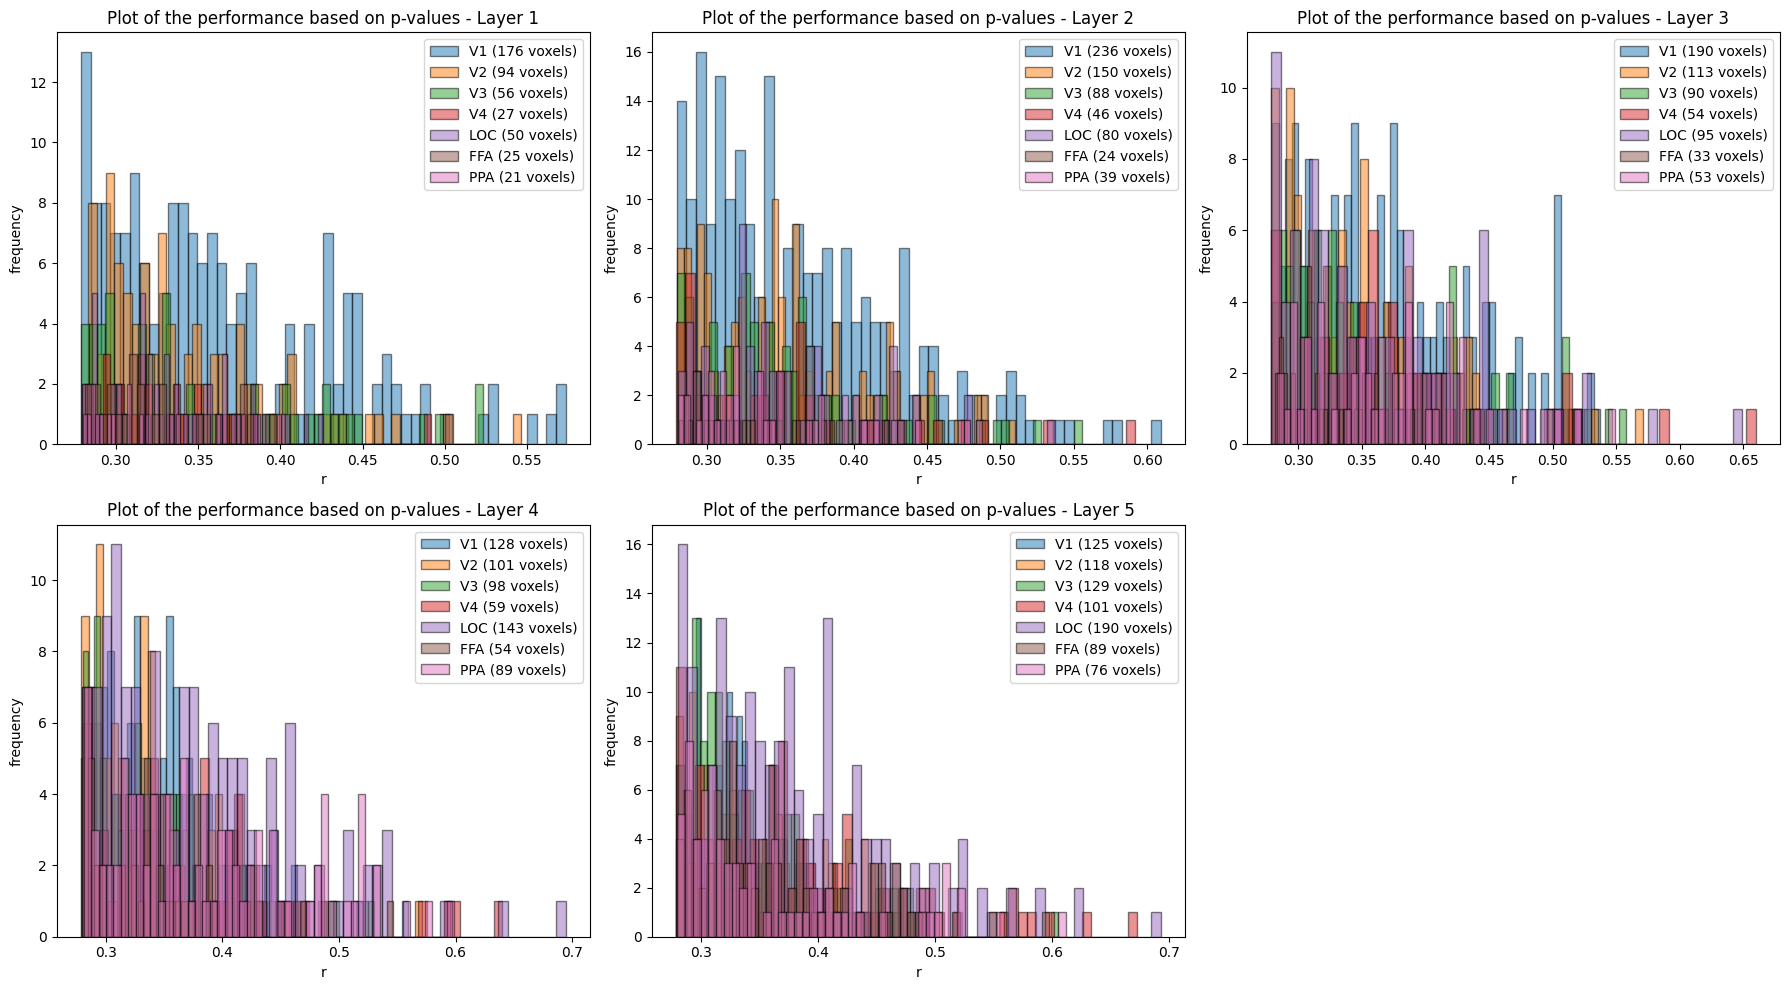

In [ ]:
#Plot the performance plot

areas_of_interest = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'PPA']
num_rows = 2
num_cols = 3

# Create a figure and an array of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 10))

# Flatten the array of subplots for easier indexing
axs = axs.flatten()

# Store voxel counts per region and per layer
voxel_counts = {area: [0] * len(corr_of_interest[0]) for area in areas_of_interest}

for area in range(len(areas_of_interest)):  # 7 areas
    for i in range(len(corr_of_interest[0])):  # 5 layers
        r = corr_of_interest[area][i][0]  # Correlations for the current area, current layer
        p = corr_of_interest[area][i][1]
        r = r[p <= 0.05]
        r = r[r > 0]
        voxel_counts[areas_of_interest[area]][i] = len(r)
        axs[i].set_title(f"Plot of the performance based on p-values - Layer {i + 1}")
        color = 'C{}'.format(area)  # Different color for each area
        axs[i].hist(r, bins=50, color=color, edgecolor='black', alpha=0.5, label=f"{areas_of_interest[area]} ({len(r)} voxels)")
        axs[i].set_xlabel('r')
        axs[i].set_ylabel('frequency')

# Update the legend for each layer
for j in range(len(corr_of_interest[0])):
    handles, labels = axs[j].get_legend_handles_labels()
    axs[j].legend(handles, labels)

# Hide any unused subplots
for j in range(len(corr_of_interest[0]), num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout()

# Save the figure
plt.savefig('my_figure.png', dpi=300)

# Display the figure
plt.show()

print("=" * 200)


In [ ]:
areas_of_interest=['V1','V2','V3','V4', 'LOC','FFA','PPA']
layers_to_study = [1, 2,3,4, 5]

def count_percentages(array,layers_to_study):
  """
    Counts the occurrences of each layer in the array and converts them to percentages.

    Parameters:
    - array (list or ndarray): The input array containing layer indices.
    - layers_to_study (list): The list of layers to study (1-based indices).

    Returns:
    - percentages (list): A list of percentages corresponding to the layers to study.
    """
    total = [x for x in array if x != 0]
    total = len(total)
    print(total)
    percentages = [0] * len(layers_to_study)  # Initialize percentages for numbers 1 to 7
    # Count occurrences of each layer
    for num in array:
        if num==0:
          continue
        if 1 <= num <= 8:
            percentages[num - 1] += 1  # Increment percentage for the number
    percentages = [p / total * 100 if total != 0 else 0 for p in percentages]# Convert counts to percentages

    return percentages

def preparation_for_percentage_plot(to_be_used_unfiltered,areas_of_interest):
    """
    Prepares data for plotting percentages of layers for each area of interest.

    Parameters:
    - to_be_used_unfiltered (list): A list of arrays containing unfiltered layer indices for each area.
    - areas_of_interest (list): A list of areas of interest.

    Returns:
    - layers_ready (list): A list of lists, where each sublist contains percentages for a specific layer across all areas.
    """
  helper=[]
  #helper=[percentagesv1,percentagesearly,percentagesventral,percentagesmt]
  # Calculate percentages for each area
  for i in range(len(areas_of_interest)):
    percentages_unfiltered = count_percentages(to_be_used_unfiltered[i],layers_to_study)
    helper.append(percentages_unfiltered)

  print(f"Filtered Actual form:{len(helper)}")

  print(f"Filtered Expected form: {len(areas_of_interest)}")

  # Rearrange the helper list to have percentages for each layer across all areas
  layers_ready=[]
  for i in range(len(helper[0])):
    temporary=[]
    for area in helper:
      curr=area[i]
      temporary.append(curr)
    layers_ready.append(temporary)

  return layers_ready


layers_ready_full= preparation_for_percentage_plot(layers_final_full_secondmine,areas_of_interest)
print(layers_ready_full)


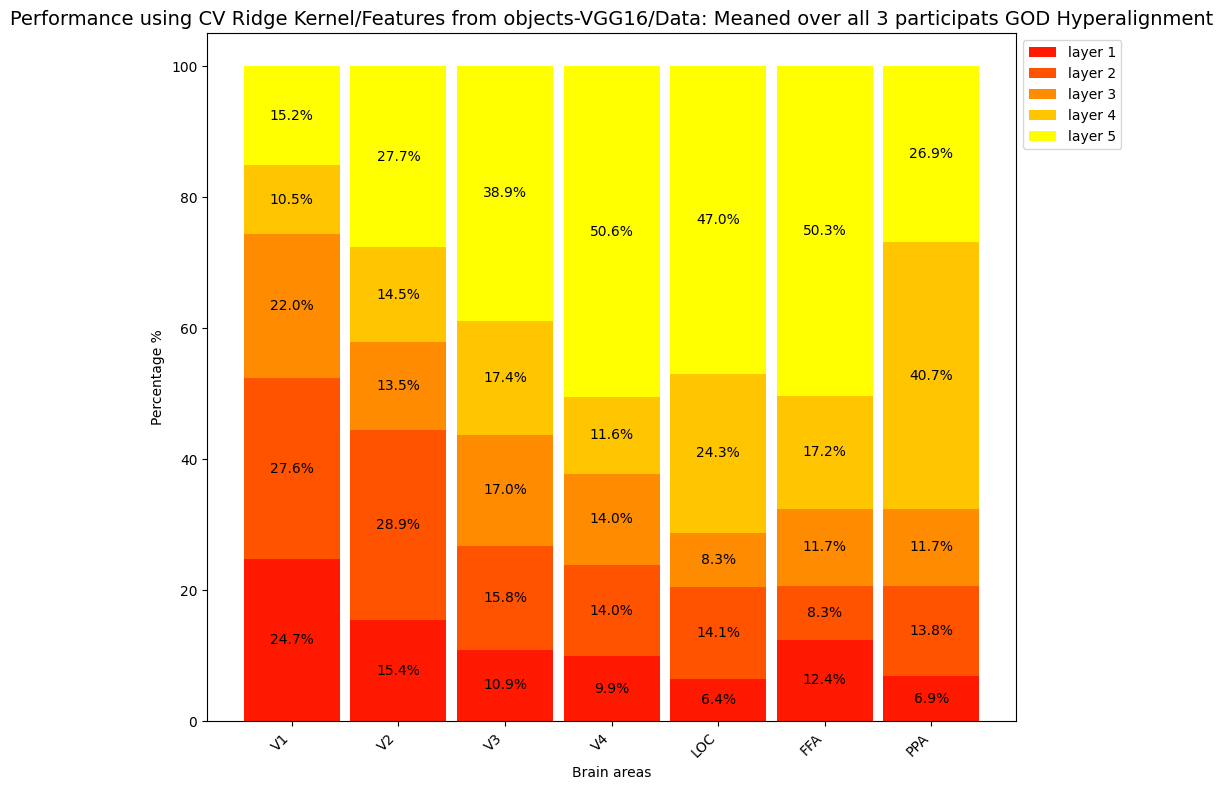

In [ ]:
#names for the x-axis
arrays_of_names = [str(element) for element in areas_of_interest]

species=arrays_of_names

#set the percentages for each layer
weight_counts = {
    "layer 1": layers_ready_full[0],
    "layer 2": layers_ready_full[1],
    "layer 3": layers_ready_full[2],
    "layer 4": layers_ready_full[3],
    "layer 5": layers_ready_full[4],

}

#set the colour map
warm_palette = plt.cm.autumn(np.linspace(0.1, 1, len(weight_counts)))

#set shape of the plot
width = 0.9
fig, ax = plt.subplots(figsize=(10, 8))
bottom = np.zeros(len(arrays_of_names))

#Plotting logic
for i, (boolean, weight_count) in enumerate(weight_counts.items()):
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom,color=warm_palette[i])
    # Adding the percentage labels on top of the bars
    for j, (height, bottom_val) in enumerate(zip(weight_count, bottom)):
        ax.text(j, bottom_val + height / 2, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='black')
    bottom += weight_count
#set title and legend
ax.set_title("Performance using CV Ridge Kernel/Features from objects-VGG16/Data: Meaned over all 3 participats GOD Hyperalignment", fontsize=14)  # Increase title font size if necessary
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right')

#set labels
ax.set_ylabel('Percentage %')
ax.set_xlabel('Brain areas')

# Adjust subplot layout to prevent overlapping titles
plt.tight_layout()

plt.show()